In [1]:
# set path
%cd /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/
#!/usr/bin/env python3
import uproot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import awkward as ak
import seaborn as sns
import os
import vector
import time
# --- CONSTANTS ---
ELECTRON_MASS = 0.000511  # GeV/c^2
MUON_MASS = 0.1057        # GeV/c^2
HIGGS_MASS = 125.0        # GeV/c^2
Z_MASS = 91.1876          # GeV/c^2

def load_data(file_paths, tree_name, columns, max_events):
    """
    Loads data from multiple ROOT files into a dictionary of Akward arrays.
    """
    data = {}
    for name, path in file_paths.items():
        print(f"Loading data from {path}...")
        try:
            with uproot.open(path) as file:
                tree = file[tree_name]
                data[name] = tree.arrays(columns, entry_stop=max_events)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            data[name] = None
    return data

# Configuration
TESTING_MODE = False
MAX_EVENTS = 100000 if TESTING_MODE else None
OUTPUT_DIR = "figure/test"
os.makedirs(OUTPUT_DIR, exist_ok=True)


file_paths = {
    "HZ4Lep": "Bg1_hz.root",
    "ZWW4Lep": "Bg2_zww.root",
    "HZ4LepLFV": "Sn1_hzLFV.root"
}

columns = [
    "MissingET_size", "MissingET.Eta", "MissingET.Phi", "MissingET.MET",
    "Jet_size", "Jet.Phi", "Jet.Eta", "Jet.PT", "Jet.Mass",
    "Electron_size", "Electron.Eta", "Electron.Phi", "Electron.PT","Electron.Charge",
    "Muon_size", "Muon.Eta", "Muon.Phi", "Muon.PT","Muon.Charge"
]

raw_data = load_data(file_paths, "Delphes", columns, MAX_EVENTS)


/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis
Loading data from Bg1_hz.root...
Loading data from Bg2_zww.root...
Loading data from Sn1_hzLFV.root...


In [2]:


def plot_three_data(data_arrays, settings, output_dir):
    """
    Generates and saves a histogram for three datasets.
    """
    if len(data_arrays) != 3:
        raise ValueError("This function requires exactly three data arrays.")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    signalType = list(data_arrays.keys())[::-1]
    
    # Handle both flattened and already flattened arrays
    a=data_arrays[signalType[2]]
    b=data_arrays[signalType[1]]
    c=data_arrays[signalType[0]]
    cutLevel=settings["prefix"]
    if cutLevel != "0unCut":
        a=a[a[cutLevel]][settings['name']]
        b=b[b[cutLevel]][settings['name']]
        c=c[c[cutLevel]][settings['name']]
    else:
        a=a[settings['name']]
        b=b[settings['name']]
        c=c[settings['name']]
    try:
        n_arr = [ak.flatten(a[~ak.is_none(a)]), 
                 ak.flatten(b[~ak.is_none(b)]), 
                 ak.flatten(c[~ak.is_none(c)])]
    except:
        n_arr = [a, b, c]
    print("Begin set bin")
    if settings['binrange'] == '':
        minlist = [ak.min(n) for n in n_arr]
        maxlist = [ak.max(n) for n in n_arr]
        settings['binrange']=(ak.min(minlist),ak.max(maxlist))
    sns.set_theme(style="ticks")
    sns.histplot(n_arr, bins=settings["bins"], binrange=settings["binrange"], ax=ax, fill=False,
                 element=settings["element"], alpha=settings["alpha"], palette=settings['colors'][::-1],
                 stat=settings["stat"], common_norm=False, multiple=settings["multiple"])
    
    ax.set_title(f"{settings['name']} - {settings['prefix']}")
    ax.set_xlabel(settings['xlabel'])
    ax.set_ylabel("Density")
    ax.legend(labels=settings['labels'])
    
    if settings['log_scale']:
        ax.set_yscale("log")

    png_name = f"{settings['prefix']}_{settings['name']}{settings['suffix']}.png"
    plt.savefig(f"{output_dir}/{png_name}")
    print(f"-> {png_name} has been plotted!")
    plt.close()


def plot_data(data_arrays, prefix, output_dir, additional_plot=False):
    """
    Orchestrates the plotting of various variables for the datasets.
    """
    plot_configs = {
        'Electron.PT': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': False},
        'Jet.PT': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': False},
        'Jet.Mass': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': True},
        'Muon.PT': {'bins': 65, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': False},
        'Electron.Eta': {'bins': 200, 'binrange': (-10, 10), 'xlabel': "", 'log_scale': False},
        'Muon.Eta': {'bins': 200, 'binrange': (-10, 10), 'xlabel': "", 'log_scale': False},
        'Electron.Phi': {'bins': 140, 'binrange': (-2 * np.pi, 2 * np.pi), 'xlabel': "", 'log_scale': False},
        'Muon.Phi': {'bins': 140, 'binrange': (-2 * np.pi, 2 * np.pi), 'xlabel': "", 'log_scale': False},
        'MissingET.MET': {'bins': 130, 'binrange': (0, 130), 'xlabel': "GeV", 'log_scale': True}
    }

    base_settings = {
        'prefix': prefix, 'element': "step", 'alpha': 0.4,
        'colors': ["#FF9966", "#6698ca", "#66cc99"],
        'labels': ["HZ4LepLFV", "ZWW4Lep", "HZ4Lep"],
        'multiple': "layer", 'stat': "density"
    }

    for name, config in plot_configs.items():
        settings = {**base_settings, **config, 'name': name}
        plot_three_data(data_arrays, settings, output_dir)

def first_cut_4l(array, name):
    """
    Filters events with exactly 4 leptons.
    """
    mask = (array["Electron_size"] + array["Muon_size"] == 4)
    # print(f"    {name}: {np.sum(mask)}/{len(mask)} : {np.sum(mask) / len(mask) * 100:.2f}%")
    return mask

def second_cut_lepton_flavor(array, name, pmask):
    """
    Filters events with an odd number of electrons and muons.
    """
    mask = (array["Electron_size"] % 2 != 0) & (array["Muon_size"] % 2 != 0) & pmask
    # print(f"    {name}: {np.sum(mask)}/{len(mask)} : {np.sum(mask) / len(mask) * 100:.2f}%")
    return mask


In [ ]:

print("\nChecking uncut events...")
for name, arr in raw_data.items():
    all_events=MAX_EVENTS if MAX_EVENTS is not None else len(arr)
    # Use a list of dictionaries for easier field addition later
    additional_fields = {}
    print(f"      {name}: {len(arr)} events")
    print(f"-> Applying cut on {name}...")
    # First cut: exactly 4 leptons
    additional_fields["1stCut"] = (arr["Electron_size"] + arr["Muon_size"] == 4)
    # Second cut: odd number leptons
    additional_fields["2ndCut"] = (arr["Electron_size"] % 2 != 0) & (arr["Muon_size"] % 2 != 0) & additional_fields["1stCut"]
    # Third cut: non charge-violation
    additional_fields["3rdCut"] = (ak.prod(arr["Electron.Charge"], axis=1) * ak.prod(arr["Muon.Charge"],axis=1) == 1
                                   )&(ak.sum(arr["Electron.Charge"],axis=1)+ak.sum(arr["Muon.Charge"],axis=1) == 0
                                      )&(ak.all(arr["Electron.Charge"],axis=1)&ak.all(arr["Muon.Charge"],axis=1)
                                      )&(additional_fields["2ndCut"] == 1)
    # Pre-Fourth cut:
    
        # test 
    # testarray=arr[additional_fields["3rdCut"]][:100]
    testarray=ak.mask(arr,additional_fields["3rdCut"])
    lmass={"Electron":ELECTRON_MASS,"Muon":MUON_MASS}
    bothZmasses={}
    bothReHiggsMass={}
    bothHiggsMass={}
    bothEditReDeMETHiggs={}
    leptons={"Electron","Muon"}
    # Useing Z mas as criterion to select lepton type
    for lepton in leptons:
        muonpaircombinations=ak.combinations(testarray[lepton+".Charge"],2,axis=1)
        muonpaircombinations_mask=muonpaircombinations['1']!=muonpaircombinations['0']
        muonpaircombinationsarg=ak.argcombinations(testarray[lepton+".Charge"],2,axis=1)
        Newmuonpairarg=ak.mask(muonpaircombinationsarg,muonpaircombinations_mask)
        FirstMuon=vector.zip({
            "pt": testarray[lepton+".PT"][Newmuonpairarg["0"]],
            "eta": testarray[lepton+".Eta"][Newmuonpairarg["0"]], 
            "phi": testarray[lepton+".Phi"][Newmuonpairarg["0"]],
            "mass": [lmass[lepton]]*muonpaircombinations_mask
        })
        SecondMuon=vector.zip({
            "pt": testarray[lepton+".PT"][Newmuonpairarg["1"]],
            "eta": testarray[lepton+".Eta"][Newmuonpairarg["1"]], 
            "phi": testarray[lepton+".Phi"][Newmuonpairarg["1"]],
            "mass": [lmass[lepton]]*muonpaircombinations_mask
        })
        MuonPair=FirstMuon+SecondMuon
        Zcandi=abs(MuonPair.mass-Z_MASS)
        BestZIndex=ak.argmin(Zcandi,axis=1,keepdims=True)
        BestZMass=ak.firsts(MuonPair.mass[BestZIndex])
        bothZmasses[lepton]=BestZMass
        RecoiledHiggsMass=(vector.obj(px=0,py=0,pz=0,energy=240)-MuonPair[BestZIndex]).mass
        bothReHiggsMass[lepton]=RecoiledHiggsMass

        selectLFV_mask=3-muonpaircombinationsarg[BestZIndex]['0']-muonpaircombinationsarg[BestZIndex]['1']
        FirstLFV=vector.zip({
            "pt": ak.firsts(testarray[lepton+".PT"][selectLFV_mask]),
            "eta": ak.firsts(testarray[lepton+".Eta"][selectLFV_mask]),
            "phi": ak.firsts(testarray[lepton+".Phi"][selectLFV_mask]),
            "mass": [lmass[lepton]]*ak.num(selectLFV_mask)
        }) # --- IGNORE ---
        anotherlepton=({"Electron","Muon"}-{lepton}).pop()
        secondLFV=vector.zip({
            "pt": ak.firsts(testarray[anotherlepton+".PT"]),
            "eta": ak.firsts(testarray[anotherlepton+".Eta"]),
            "phi": ak.firsts(testarray[anotherlepton+".Phi"]),
            "mass": [lmass[anotherlepton]]*ak.num(selectLFV_mask)
        }) # --- IGNORE ---
        HiggsM=(FirstLFV+secondLFV).mass
        bothHiggsMass[lepton]=HiggsM

    # Using Higgs mass as criterion to select lepton type
    HiggsPairCandidates=ak.cartesian([testarray["Electron.Charge"],testarray["Muon.Charge"]],axis=1)
    HiggsPairCandidates_mask=(HiggsPairCandidates['0']!=HiggsPairCandidates['1'])
    HiggsPairCandidatesarg=ak.argcartesian([testarray["Electron.Charge"],testarray["Muon.Charge"]],axis=1)
    HiggsPairCandidatesarg=ak.mask(HiggsPairCandidatesarg,HiggsPairCandidates_mask)
    FirstHiggsInPair=vector.zip({
        "pt": testarray["Electron.PT"][HiggsPairCandidatesarg["0"]],
        "eta": testarray["Electron.Eta"][HiggsPairCandidatesarg["0"]], 
        "phi": testarray["Electron.Phi"][HiggsPairCandidatesarg["0"]],
        "mass": [ELECTRON_MASS]*ak.num(HiggsPairCandidates_mask)
    })
    SecondHiggsInPair=vector.zip({
        "pt": testarray["Muon.PT"][HiggsPairCandidatesarg["1"]],
        "eta": testarray["Muon.Eta"][HiggsPairCandidatesarg["1"]], 
        "phi": testarray["Muon.Phi"][HiggsPairCandidatesarg["1"]],
        "mass": [MUON_MASS]*ak.num(HiggsPairCandidates_mask)
    })
    HiggsPair=FirstHiggsInPair+SecondHiggsInPair
    HiggsPairMass=HiggsPair.mass
    HiggsPairDeltaMass=abs(HiggsPairMass-HIGGS_MASS)
    BestHiggsPairIndex=ak.argmin(HiggsPairDeltaMass,axis=1,keepdims=True)
    BestHiggsPairMass=ak.firsts(HiggsPairMass[BestHiggsPairIndex])
    ZRecoiledMass=(vector.obj(px=0,py=0,pz=0,energy=240)-HiggsPair[BestHiggsPairIndex]).mass
    # Selecting lepton type for Z reconstruction based on Higgs mass
    PTlTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.PT"],arr["Electron.PT"])
    EataLTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.Eta"],arr["Electron.Eta"])
    PhiLTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.Phi"],arr["Electron.Phi"])
    LTypeCandidateMass=ak.where(arr["Electron_size"]==1,MUON_MASS,ELECTRON_MASS)
    LTypeCandidate=vector.zip({
        "pt": PTlTypeCandidate,
        "eta": EataLTypeCandidate, 
        "phi": PhiLTypeCandidate,
        "mass": LTypeCandidateMass
    })
    num=len(BestHiggsPairIndex)
    NotNone_mask=~ak.is_none(BestHiggsPairIndex)
    row=np.arange(num)
    Zpair_mask=np.full((num,3),True)
    Zpair_mask[row[NotNone_mask],ak.firsts(BestHiggsPairIndex[NotNone_mask])]=False
    Zpair_mask=ak.mask(Zpair_mask,NotNone_mask)
    RecoZpair=ak.combinations(LTypeCandidate[Zpair_mask],2,axis=1)
    Zpair=RecoZpair['0']+RecoZpair['1']
    ZpairMass=Zpair.mass
    # Identifying lepton type based on Z mass
    ZfirstLFlavor=ak.where(arr['Electron_size']==3,["EE"],["MuMu"])


    additional_fields["Z_selectionMass"]=ak.where(~ak.is_none(bothZmasses["Electron"]),bothZmasses["Electron"],bothZmasses["Muon"])
    additional_fields["Higgs_recoiledMass"]=ak.firsts(ak.where(~ak.is_none(bothZmasses["Electron"]),bothReHiggsMass["Electron"],bothReHiggsMass["Muon"]))
    additional_fields["Higgs_reconstructedMass"]=ak.where(~ak.is_none(bothHiggsMass["Electron"]),bothHiggsMass["Electron"],bothHiggsMass["Muon"])
    additional_fields["Higgs_selectionMass"]=BestHiggsPairMass
    additional_fields["Z_recoiledMass"]=ak.firsts(ZRecoiledMass)
    additional_fields["Z_reconstructedMass"]=ak.firsts(ZpairMass)
    # Fourth cut: Higgs mass window 110-127.5 GeV
    additional_fields["4thCut1Med"] = (additional_fields["Higgs_reconstructedMass"] > 110) & (additional_fields["Higgs_reconstructedMass"] < 127.5) & additional_fields["3rdCut"]
    additional_fields["4thCut2Med"] = (additional_fields["Higgs_selectionMass"] > 110) & (additional_fields["Higgs_selectionMass"] < 127.5) & additional_fields["3rdCut"]
    additional_fields["Zpair"]=ZfirstLFlavor
    additional_fields["HiggsPair"]=["EMu"]*len(BestHiggsPairMass)
    # Add all new fields to the array at once
    for field_name, field_values in additional_fields.items():
        raw_data[name] = ak.with_field(raw_data[name], field_values, field_name)
print("----------------------------***-------------------------------")



Checking uncut events...
      HZ4Lep: 1000000 events
-> Applying cut on HZ4Lep...
      ZWW4Lep: 1000000 events
-> Applying cut on ZWW4Lep...
      HZ4LepLFV: 1000000 events
-> Applying cut on HZ4LepLFV...
----------------------------***-------------------------------


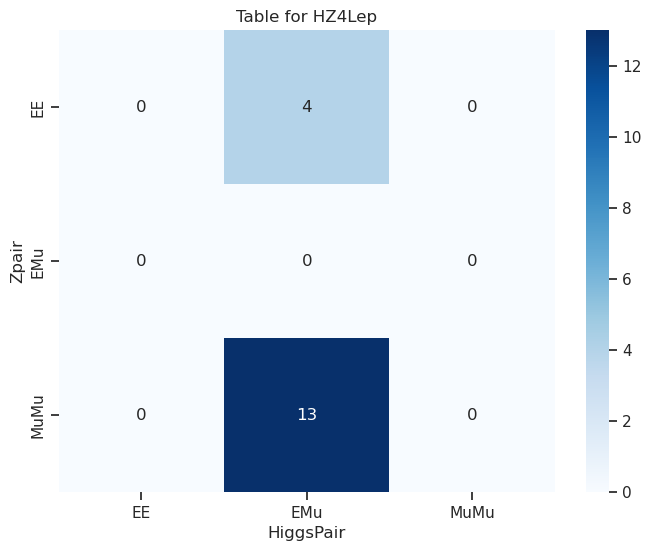

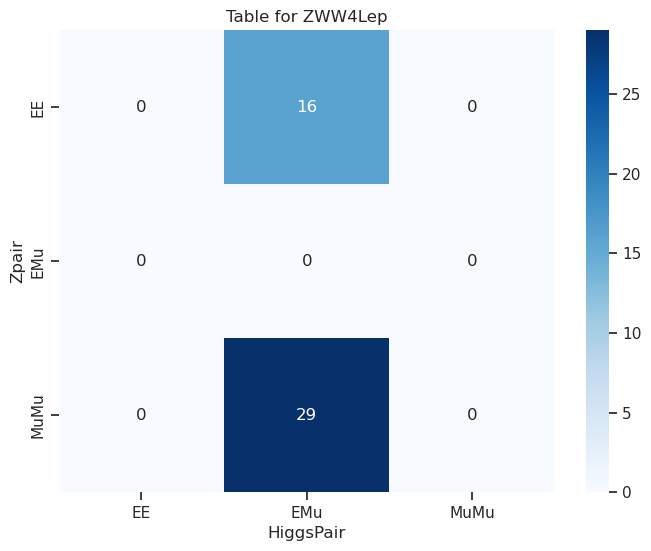

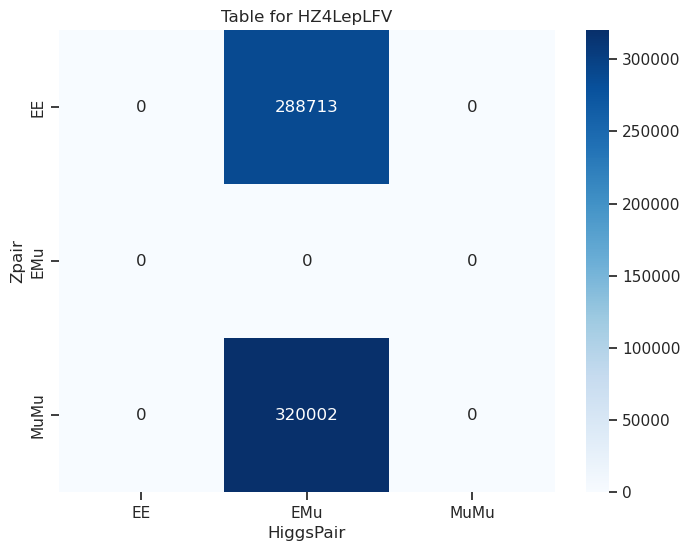

In [33]:
# plot confusion matrix on Zpair and HiggsPair
# --- IGNORE ---
for name, arr in raw_data.items():
    filtered_arr = ak.mask(arr, arr["4thCut1Med"])
    possible_pairs=['EE','EMu','MuMu']
    df=pd.DataFrame({"Zpair":ak.to_list(filtered_arr["Zpair"]),"HiggsPair":ak.to_list(filtered_arr["HiggsPair"])})
    confusion_matrix=pd.crosstab(df['Zpair'],df['HiggsPair'],rownames=['Zpair'],colnames=['HiggsPair'])
    confusion_matrix = confusion_matrix.reindex(index=possible_pairs, columns=possible_pairs, fill_value=0)
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Table for {name}')
    # plt.savefig(f"{OUTPUT_DIR}/Confusion_Matrix_{name}.png")
    plt.show()
    plt.close()

In [4]:

plot_configs = {
    'Z_selectionMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
    'Higgs_recoiledMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
    'Higgs_reconstructedMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
    'Higgs_selectionMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
    'Z_recoiledMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
    'Z_reconstructedMass': {'bins': 400, 'binrange': '', 'xlabel': "GeV", 'log_scale': False, 'suffix': ''},
    'Higgs_recoiledMass_1': {'bins': 50, 'binrange': (110,150), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom'},
    'Higgs_reconstructedMass_1': {'bins': 20, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom_1bin'},
    'Higgs_reconstructedMass_2': {'bins': 100, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom_detailedbin'},
    'Higgs_reconstructedMass_3': {'bins': 20, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom_1bincount','stat':"count"},
    'Higgs_selectionMass_1': {'bins': 20, 'binrange': (110,130), 'xlabel': "GeV", 'log_scale': False, 'suffix': '_zoom'}
}

base_settings = {
    'prefix': '3rdCut', 'element': "step", 'alpha': 1,
    'colors': ["#FF9966", "#6698ca", "#66cc99"],
    'labels': ["HZ4LepLFV", "ZWW4Lep", "HZ4Lep"],
    'multiple': "layer", 'stat': "density"
}
for name, config in plot_configs.items():
    if plot_configs[name].get('suffix') != '':
        name=name[:-2]
    settings = {**base_settings,**config, 'name': name}
    plot_three_data(raw_data, settings, 'Figure')


Begin set bin
-> 3rdCut_Z_selectionMass.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_recoiledMass.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_reconstructedMass.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_selectionMass.png has been plotted!
Begin set bin
-> 3rdCut_Z_recoiledMass.png has been plotted!
Begin set bin
-> 3rdCut_Z_reconstructedMass.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_recoiledMass_zoom.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_reconstructedMass_zoom_1bin.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_reconstructedMass_zoom_detailedbin.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_reconstructedMass_zoom_1bincount.png has been plotted!
Begin set bin
-> 3rdCut_Higgs_selectionMass_zoom.png has been plotted!


In [7]:
# Formatted Cut Report Table
# Assuming 'raw_data' is a dictionary structured like this:
# raw_data = {
#     'Dataset_A': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
#     'Dataset_B': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
# }

cut_list = ["1stCut", "2ndCut", "3rdCut", "4thCut1Med", "4thCut2Med"]
data_names = list(raw_data.keys())

# --- Define Column Widths for Formatting ---
# Adjust these values as needed for your data names
header_col_width = 15
data_col_width = 25

# --- Print Table Header ---
# Start with an empty cell for the top-left corner
header = f"{'Cut Name':<{header_col_width}}"
# Add each dataset name as a column header
for name in data_names:
    header += f"{name:<{data_col_width}}"
print(header)
print("-" * len(header)) # Print a separator line

# --- Print Data Rows ---
for cut_name in cut_list:
    # Start the row with the current cut name
    row_str = f"{cut_name:<{header_col_width}}"
    
    # Iterate through each dataset to get the corresponding data for the current cut
    for name in data_names:
        arr = raw_data[name]
        # Get total events from the first cut (as in the original code)
        total_events = len(arr["1stCut"])
        
        # Calculate passed events for the current cut
        mask = arr[cut_name]
        passed_events = np.sum(mask)
        
        # Avoid division by zero
        if total_events > 0:
            percentage = (passed_events / total_events) * 100
            cell_content = f"{passed_events}/{total_events} ({percentage:.2f}%)"
        else:
            cell_content = "0/0 (N/A)"
            
        # Add the formatted data cell to the row string
        row_str += f"{cell_content:<{data_col_width}}"
        
    print(row_str)

print("\nAll done!")

Cut Name       HZ4Lep                   ZWW4Lep                  HZ4LepLFV                
------------------------------------------------------------------------------------------
1stCut         590512/1000000 (59.05%)  590606/1000000 (59.06%)  652031/1000000 (65.20%)  
2ndCut         294732/1000000 (29.47%)  294795/1000000 (29.48%)  651969/1000000 (65.20%)  
3rdCut         294689/1000000 (29.47%)  294758/1000000 (29.48%)  651931/1000000 (65.19%)  
4thCut1Med     17/1000000 (0.00%)       45/1000000 (0.00%)       608715/1000000 (60.87%)  
4thCut2Med     7013/1000000 (0.70%)     7085/1000000 (0.71%)     640617/1000000 (64.06%)  

All done!
